In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt

2023-06-25 22:12:29.885427: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 22:12:29.950181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 22:12:31.780789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data and normalization

In [2]:
print("[INFO] loading dataset...")

path = os.path.join("dataset", "image-bounding")

print("[INFO] Load image from path...")

images = []
labels = []

for label in os.listdir(path):
    label_path = os.path.join(path, label)
    
    for image in os.listdir(label_path):
        path_image = os.path.join(label_path, image)
        
        img = load_img(path_image, target_size=(160, 320))
        img = img_to_array(img)
        images.append(img)
        labels.append(label)
        
print("[INFO] Success load image from path...")

images = np.array(images)/255.
labels = np.array(labels)

print("[INFO] Load labels to one hot encoding...")
encoding = OneHotEncoder()
labels = encoding.fit_transform(labels.reshape(-1, 1)).toarray()
print("[INFO] Success load labels to one hot encoding...")


print("[INFO] Success loading dataset")

[INFO] loading dataset...
[INFO] Load image from path...
[INFO] Success load image from path...
[INFO] Load labels to one hot encoding...
[INFO] Success load labels to one hot encoding...
[INFO] Success loading dataset


## Split data training and data validation

In [3]:
split = train_test_split(images, labels, test_size=0.10, random_state=42)

(train_image, test_image) = split[:2]
(train_label, test_label) = split[2:4]

## Model

In [4]:
mobile_net = MobileNetV2(
    weights = "imagenet", 
    include_top = False,
    input_tensor = Input(shape = (160, 320, 3), name = "image")
)

mobile_net.trainable = False
    
flatten = mobile_net.output
flatten = Flatten()(flatten)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(2, activation="softmax",
                    name="class_label")(softmaxHead)

model = Model(
    inputs = mobile_net.input,
    outputs = softmaxHead
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 160, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 160, 32)  864         ['image[0][0]']                  
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 160, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 160, 32)  0           ['bn_Conv1[0][0]']           

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 20, 40, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 40, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 40, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 40, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 20, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 20, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 20, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 20, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 20, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 20, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 20, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 20, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 10, 960)  3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 10, 960)  0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 10, 160)   153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 10, 160)  640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

In [5]:
plot_model(
    model,
    show_shapes=True, 
    show_dtype=False, 
    show_layer_names=True, 
    expand_nested=True
)

## Training Model

In [6]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"], loss_weights = 1.0)

print("[INFO] training model...")
history = model.fit(
    train_image, train_label,
    validation_data = (test_image, test_label),
    batch_size = 32,
    epochs = 20,
    verbose = 1
)

[INFO] training model...
Epoch 1/20


2023-06-25 22:12:43.811467: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 755712000 exceeds 10% of free system memory.


39/39 [==============================] - 63s 2s/step - loss: 1.1626 - accuracy: 0.6862 - val_loss: 0.2551 - val_accuracy: 0.8832
Epoch 2/20
39/39 [==============================] - 57s 1s/step - loss: 0.4073 - accuracy: 0.8618 - val_loss: 0.2437 - val_accuracy: 0.8759
Epoch 3/20
39/39 [==============================] - 55s 1s/step - loss: 0.2558 - accuracy: 0.9179 - val_loss: 0.2144 - val_accuracy: 0.9051
Epoch 4/20
39/39 [==============================] - 58s 1s/step - loss: 0.1653 - accuracy: 0.9520 - val_loss: 0.1815 - val_accuracy: 0.8978
Epoch 5/20
39/39 [==============================] - 59s 2s/step - loss: 0.1192 - accuracy: 0.9610 - val_loss: 0.1504 - val_accuracy: 0.9197
Epoch 6/20
39/39 [==============================] - 56s 1s/step - loss: 0.1002 - accuracy: 0.9707 - val_loss: 0.1497 - val_accuracy: 0.9343
Epoch 7/20
39/39 [==============================] - 56s 1s/step - loss: 0.0674 - accuracy: 0.9829 - val_loss: 0.1504 - val_accuracy: 0.9124
Epoch 8/20
39/39 [=============

## Saving model

In [7]:
is_dir_model_exist = os.path.exists("model")
if not is_dir_model_exist:
    os.makedirs("model")
    
model_path = os.path.join("model")

print("[INFO] saving object classification model...")
model.save("{}/model-classification.h5".format(model_path), save_format="h5")
print("[INFO] success saving object classification model")

print("[INFO] saving label one hot encoding...")
f = open("{}/one-hot-classification.pickle".format(model_path), "wb")
f.write(pickle.dumps(encoding))
f.close()
print("[INFO] success saving label one hot encoding")

[INFO] saving object classification model...
[INFO] success saving object classification model
[INFO] saving label one hot encoding...
[INFO] success saving label one hot encoding


## Losses Graph

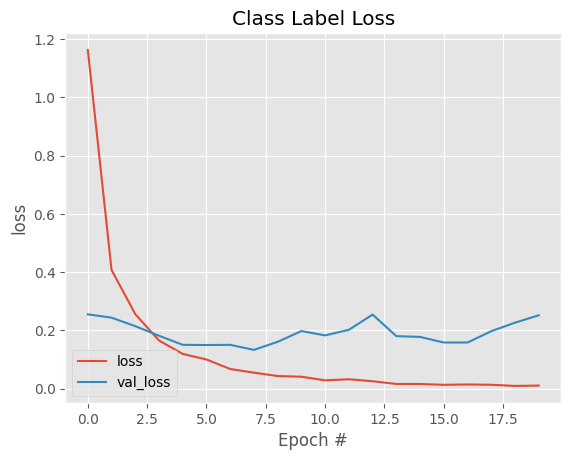

In [14]:
is_dir_result_exist = os.path.exists("result")
if not is_dir_result_exist:
    os.makedirs("result")

result_path = os.path.join("result")
n_epoch = np.arange(0, 20)

plt.style.use("ggplot")
plt.figure()
plt.plot(
    n_epoch, 
    history.history["loss"],
    label="loss"
)
plt.plot(
    n_epoch,
    history.history["val_loss"],
    label="val_loss"
)
plt.title("Class Label Loss")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

plotPath = os.path.sep.join([result_path, "losses-classification.png"])
plt.savefig(plotPath)
plt.show()
plt.close()

## Label Accuracy

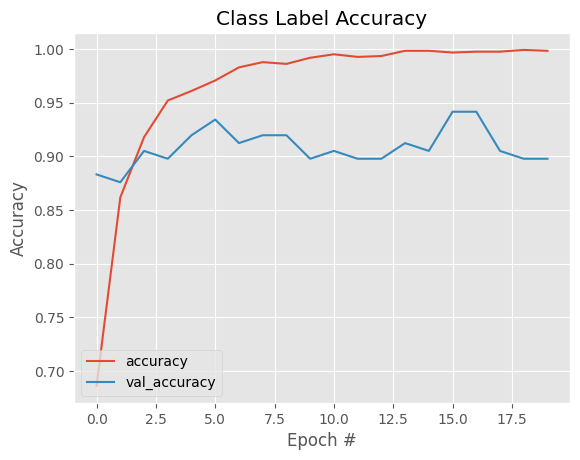

In [13]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(
    n_epoch, 
    history.history["accuracy"],
    label="accuracy"
)
plt.plot(
    n_epoch,
    history.history["val_accuracy"],
    label="val_accuracy"
)
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plotPath = os.path.sep.join([result_path, "accs-classification.png"])
plt.savefig(plotPath)
plt.show()
plt.close()